In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#figure stuff
plt.rcParams['axes.grid']=True
plt.rcParams['axes.axisbelow'] = True
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['axes.titleweight']="bold"
plt.rcParams['mathtext.default']=u'regular'

In [3]:
# read in the files 

study_dates = pd.read_csv('nct2date.csv', parse_dates=['study_first_submitted'])
study_dates['year'] = study_dates['study_first_submitted'].apply(lambda x: x.year)
study_dates.head()

,nct_id,intervention_name,study_first_submitted,year
0,NCT02679326,Therapeutic ultrasound,2016-02-07,2016
1,NCT02676362,Gingival crevicular fluid collection with filt...,2016-02-01,2016
2,NCT02672930,Electrocardiogram (ECG),2016-01-17,2016
3,NCT02675283,Simtomax,2016-01-25,2016
4,NCT02677220,CI532 cochlear implant,2016-02-03,2016


In [4]:
# add information about disease
disease_df=pd.read_csv('conditions.txt',sep='|')
disease_df.head()

,id,nct_id,name,downcase_name
0,4306861,NCT04328025,HIV,hiv
1,4307524,NCT04323176,Hiv,hiv
2,4308169,NCT04318509,PKU,pku
3,4308872,NCT04313699,Aging,aging
4,4310806,NCT04299854,Obese,obese


In [5]:
df = pd.read_table('outcome_analyses.txt', sep='|', low_memory=False)
df = pd.merge(df, study_dates, on='nct_id')

df=pd.merge(df, disease_df[['nct_id','downcase_name']], on='nct_id')

#Get rid of p-values that are not percentages or between 0 and 1
df = df[~((df['p_value']>100) | (df['p_value']<0))].reset_index(drop=True)
is_percentage = df['p_value_description'].str.contains('denoted in percentage', case=False).fillna(False)
df['p_value'] = (df['p_value'] / 100.).where(is_percentage, other=df['p_value']) 
df = df[~((df['p_value']>1) | (df['p_value']<0))].reset_index(drop=True)
df = df[~df['p_value'].isnull()]

df.head()

,id,nct_id,outcome_id,non_inferiority_type,non_inferiority_description,param_type,param_value,dispersion_type,dispersion_value,p_value_modifier,...,p_value_description,method,method_description,estimate_description,groups_description,other_analysis_description,intervention_name,study_first_submitted,year,downcase_name
0,1157332,NCT04072432,2107907,Other,Analyses of variance for repeated measures (AN...,Mean Difference (Final Values),18.0,NaN,NaN,NaN,...,p values were corrected for multiple compariso...,ANOVA,ANOVA for repeated measures,NaN,NaN,NaN,Iron sucrose,2019-08-26,2019,"kidney failure, acute"
1,1157345,NCT04012970,2108007,Superiority,NaN,NaN,NaN,NaN,NaN,<,...,NaN,ANOVA,"2-way, repeated measures",NaN,NaN,NaN,Manual spinal mobilisations,2019-07-03,2019,lower back pain
2,1157346,NCT04012970,2108008,Superiority,NaN,NaN,NaN,NaN,NaN,<,...,NaN,ANOVA,"2-way, repeated measures",NaN,NaN,NaN,Manual spinal mobilisations,2019-07-03,2019,lower back pain
3,1157347,NCT04012970,2108009,Superiority,NaN,NaN,NaN,NaN,NaN,<,...,NaN,ANCOVA,NaN,NaN,Tone change ran with covariates (baseline stif...,NaN,Manual spinal mobilisations,2019-07-03,2019,lower back pain
4,1157348,NCT04012970,2108009,Superiority,NaN,NaN,NaN,NaN,NaN,<,...,NaN,ANOVA,"2-way, repeated measures",NaN,NaN,NaN,Manual spinal mobilisations,2019-07-03,2019,lower back pain


In [6]:
#ok, now, write df to a dataframe so that when I make plot notebooks it is simple
df.to_csv('working_df.tsv',sep='\t')

# Asset 1: diseases relevant to clinical trials through time 
- Here I the diseases relevant to clinical trials have changed over time

In [7]:
len(df.groupby('downcase_name')['nct_id'].count().sort_values(ascending=False))

1842

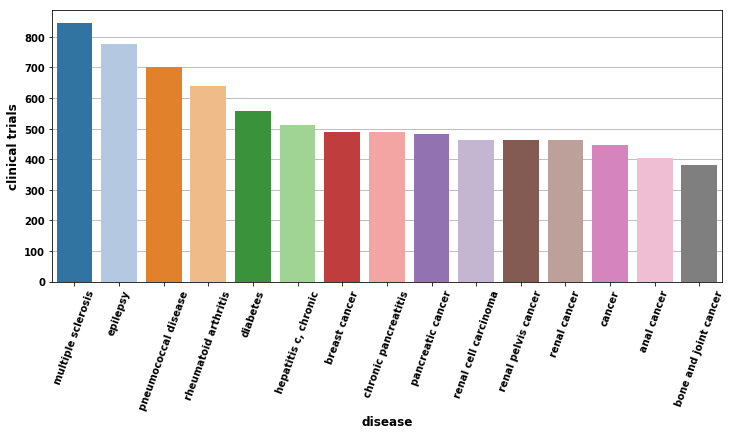

In [8]:
#let's see what the most studies disease are
plt.figure(figsize=(12,5))
t=pd.DataFrame(df.groupby('downcase_name')['nct_id'].count().sort_values(ascending=False))
sns.barplot(x=t.index[0:15],y=t['nct_id'][0:15], data=t[0:15],palette='tab20')
plt.xticks(rotation=70)
plt.ylabel('clinical trials',size=12)
plt.xlabel('disease',size=12)

disease_order=t.index[0:14]

/home/ian/anaconda3/envs/FACS_Env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0, 0.5, 'fraction of clinical trials')

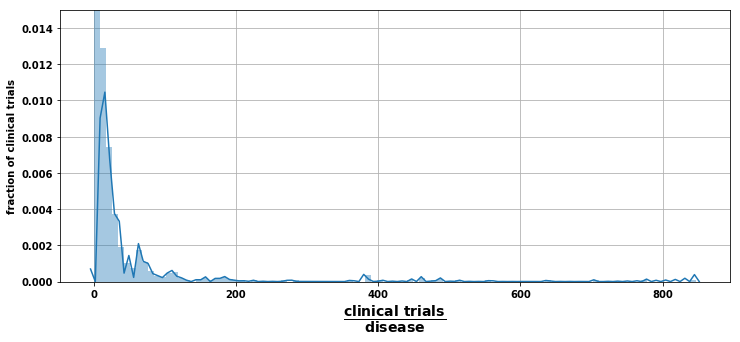

In [9]:
# now let's plot the total distribution of clinical trials
plt.figure(figsize=(12,5))
sns.distplot(t['nct_id'], bins=100)
plt.ylim(0,0.015)
plt.xlabel(r'$\frac{clinical\ trials}{disease}$',size=20)
plt.ylabel('fraction of clinical trials')

In [10]:
# now I want to know plot how the clinical trials for the most popular disease are distributed accross time
POPULAR_CUTOFF = 15

downcase_name_by_popularity = df.groupby('downcase_name')['nct_id'].nunique().sort_values(ascending=False).index.tolist()
popular_downcase_name = downcase_name_by_popularity[:POPULAR_CUTOFF]

m = df.groupby(['downcase_name','year'])['nct_id'].nunique().unstack().fillna(0)
row_normalized_m = m.sub(m.mean(axis=1), axis=0).div(m.std(axis=1), axis=0)
col_normalized_m = m.T.sub(m.T.mean(axis=1), axis=0).div(m.T.std(axis=1), axis=0).T

Text(0.5, 0.98, 'col z-score')

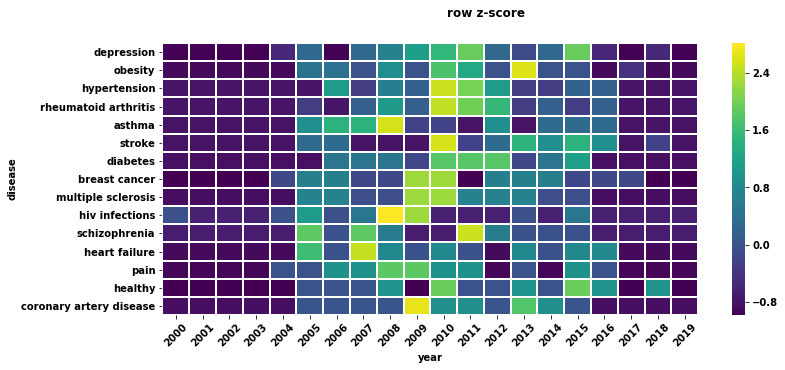

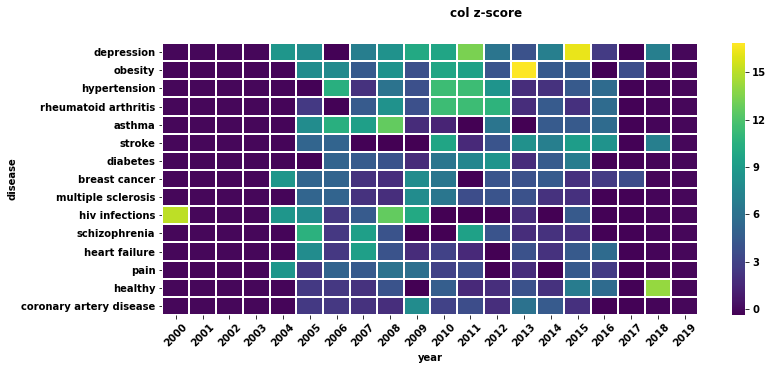

In [11]:
#plt.figure(figsize=(12,5))
#sns.heatmap(m.loc[popular_downcase_name], linewidths=1, cmap='viridis',  xticklabels=True, yticklabels=True)
#plt.xticks(rotation=45)

plt.figure(figsize=(12,5))
sns.heatmap(row_normalized_m.loc[popular_downcase_name], linewidths=1, cmap='viridis',  xticklabels=True, yticklabels=True)
plt.xticks(rotation=45)
plt.ylabel('disease')
plt.suptitle('row z-score', weight='bold')

plt.figure(figsize=(12,5))
sns.heatmap(col_normalized_m.loc[popular_downcase_name], linewidths=1, cmap='viridis',  xticklabels=True, yticklabels=True)
plt.xticks(rotation=45)
plt.ylabel('disease')
plt.suptitle('col z-score', weight='bold')

In [12]:
subset = row_normalized_m.loc[downcase_name_by_popularity[:15]].diff(axis=1).fillna(0)

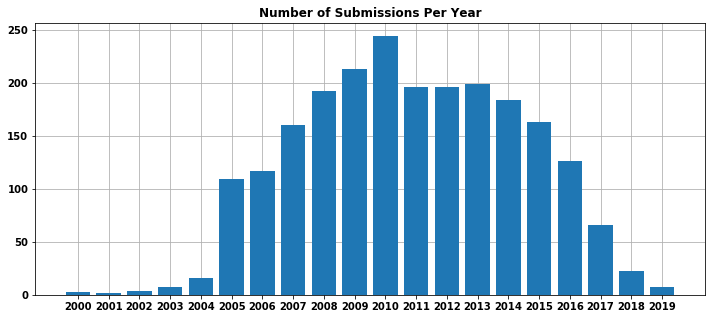

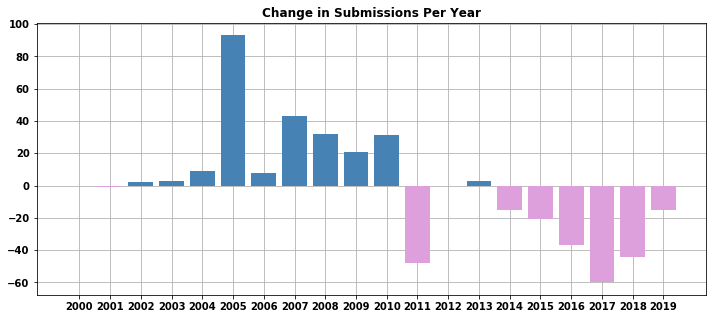

In [13]:
plt.figure(figsize=(12,5))
submissions_per_year = df.groupby('year')['nct_id'].nunique().reset_index()
plt.bar(submissions_per_year['year'], submissions_per_year['nct_id'])
plt.title('Number of Submissions Per Year')
_ = plt.xticks(subset.columns)


plt.figure(figsize=(12,5))
submission_change = submissions_per_year.set_index('year').nct_id.diff().fillna(0)

positive = submission_change[submission_change>0].reset_index()
nonpositive = submission_change[submission_change<=0].reset_index()

plt.bar(positive['year'], positive['nct_id'], color='steelblue')
plt.bar(nonpositive['year'], nonpositive['nct_id'], color='plum')

plt.title('Change in Submissions Per Year')
_ = plt.xticks(subset.columns)

# Part 2: Trial sucess through time
- This notebook is continues from Part 1
- Here I wish to visualize the relationship between a trial's success (indicated by a small p-value) and time 

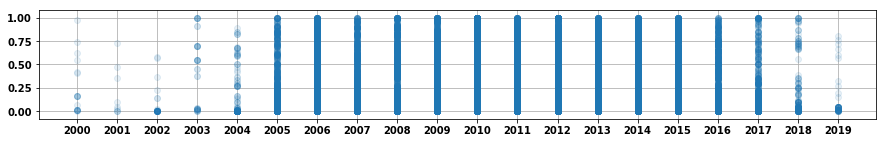

In [14]:
plt.figure(figsize=(15,2))
plt.scatter(df['year'], df['p_value'], alpha=0.1)
_ = plt.xticks(sorted(df['year'].unique()))

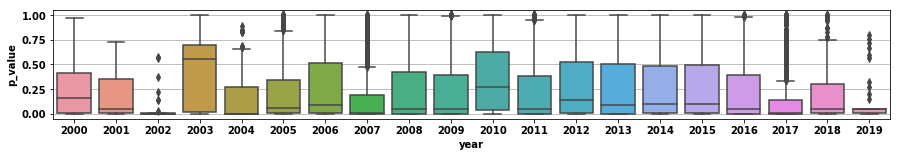

In [15]:
plt.figure(figsize=(15,2))
sns.boxplot(df['year'], df['p_value'])

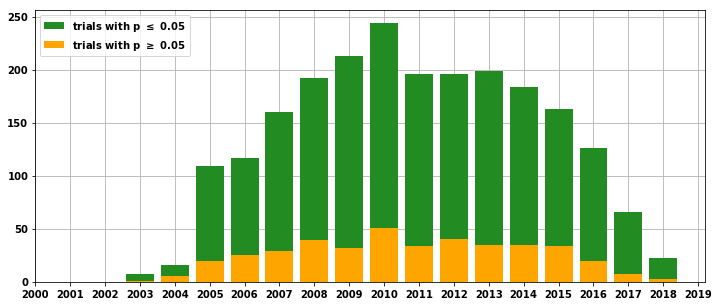

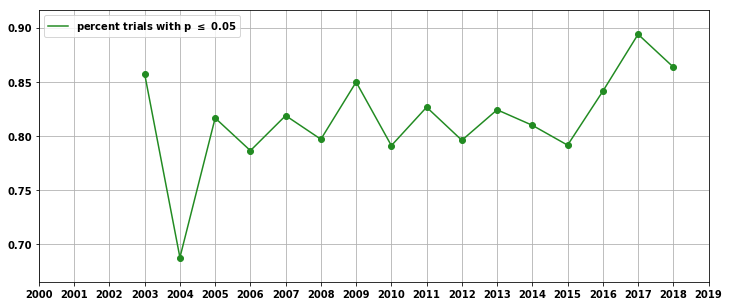

In [16]:
df['min_pvalue'] = df.groupby(['nct_id'])['p_value'].transform('min')
df['has_p≤0.05'] = df['min_pvalue'] <= 0.05
n_significant_by_year = df.groupby(['year','has_p≤0.05'])['nct_id'].nunique().unstack()

plt.figure(figsize=(12,5))

for i, row in n_significant_by_year.iterrows(): #add a legend or remove picture!
    plt.bar(i, row[False]+row[True], color='forestgreen')
    plt.bar(i, row[False], color='orange')

_ = plt.xticks(subset.columns)
plt.legend(['trials with p $\leq$ 0.05','trials with p $\geq$ 0.05'],loc='upper left')



plt.figure(figsize=(12,5))
perc_positive = n_significant_by_year[True]/(n_significant_by_year[False]+n_significant_by_year[True])

plt.scatter(perc_positive.index.tolist(), perc_positive.values, color='forestgreen')
plt.plot(perc_positive.index.tolist(), perc_positive.values, color='forestgreen')
plt.legend(['percent trials with p $\leq$ 0.05'])
    
    
_ = plt.xticks(subset.columns)

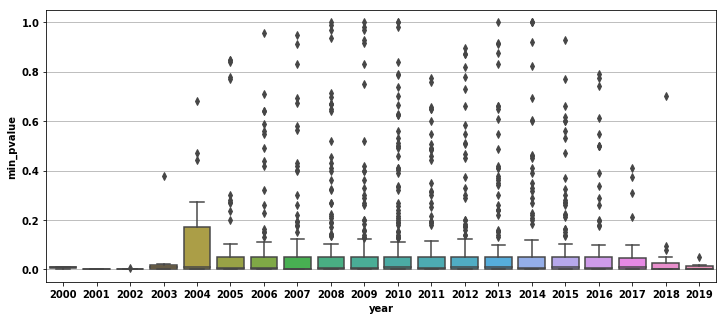

In [17]:
nct_pvalues = df.drop_duplicates(subset='nct_id')[['nct_id','year','min_pvalue']].dropna()

plt.figure(figsize=(12,5))
sns.boxplot(data=nct_pvalues, x='year', y='min_pvalue')

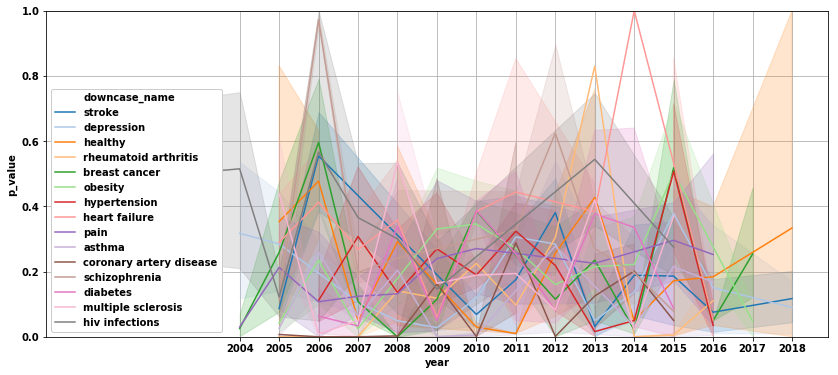

In [18]:
temp=df[df['downcase_name'].isin(downcase_name_by_popularity[0:15])]
plt.figure(figsize=(14,6))
sns.lineplot(x='year',
             y='p_value',
             hue='downcase_name',
             palette='tab20',
             ci=95,
             legend='full',
             data=temp)

plt.xticks(sorted(temp.year.unique()[:-1]))
plt.ylim(0,1)
plt.legend(loc='lower left',fancybox=True, framealpha=1)

In [19]:
temp.head()

,id,nct_id,outcome_id,non_inferiority_type,non_inferiority_description,param_type,param_value,dispersion_type,dispersion_value,p_value_modifier,...,method_description,estimate_description,groups_description,other_analysis_description,intervention_name,study_first_submitted,year,downcase_name,min_pvalue,has_p≤0.05
175,1159000,NCT03559829,2110241,Other,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,RAPAEL Smart Glove,2018-06-01,2018,stroke,0.01,True
176,1159001,NCT03559829,2110242,Other,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,RAPAEL Smart Glove,2018-06-01,2018,stroke,0.01,True
177,1159002,NCT03559829,2110243,Other,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,RAPAEL Smart Glove,2018-06-01,2018,stroke,0.01,True
178,1159003,NCT03559829,2110244,Other,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,RAPAEL Smart Glove,2018-06-01,2018,stroke,0.01,True
179,1159004,NCT03559829,2110245,Other,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,RAPAEL Smart Glove,2018-06-01,2018,stroke,0.01,True


In [20]:
#ok, so I don't see what's up with the 
temp.groupby('downcase_name')['p_value'].mean()

downcase_name
asthma                     0.089777
breast cancer              0.349698
coronary artery disease    0.159203
depression                 0.199659
diabetes                   0.365682
healthy                    0.264106
heart failure              0.314887
hiv infections             0.277343
hypertension               0.201472
multiple sclerosis         0.212799
obesity                    0.235593
pain                       0.205479
rheumatoid arthritis       0.181548
schizophrenia              0.235595
stroke                     0.169842
Name: p_value, dtype: float64

In [21]:
#ok, so that is interesting, now I want to color the plots somehow...
# I want to see if there is a year specific component to the odd humps in the data
# so, I want to give each point a year specific color
p=sns.color_palette("tab20") # maybe use a sequential palette?
c_dict=dict()
r=range(2000,2020)
for i,j in zip(r,range(0,len(r))):
    c_dict[i]=j

In [22]:
nct_pvalues['year_color']=[c_dict[i] for i in nct_pvalues['year']]

(0, 2500)

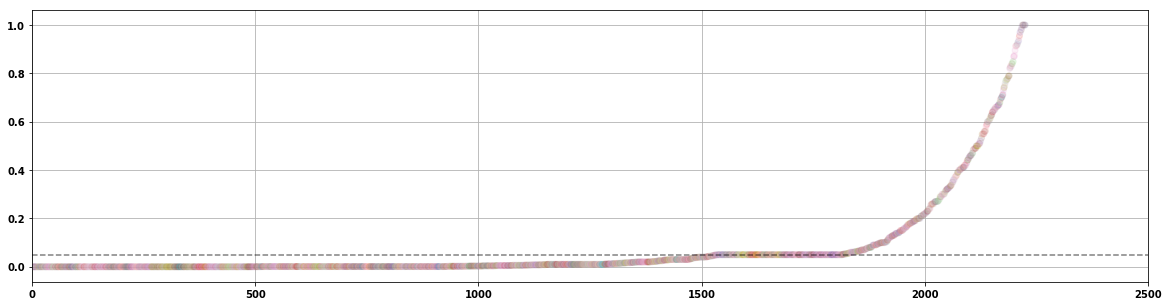

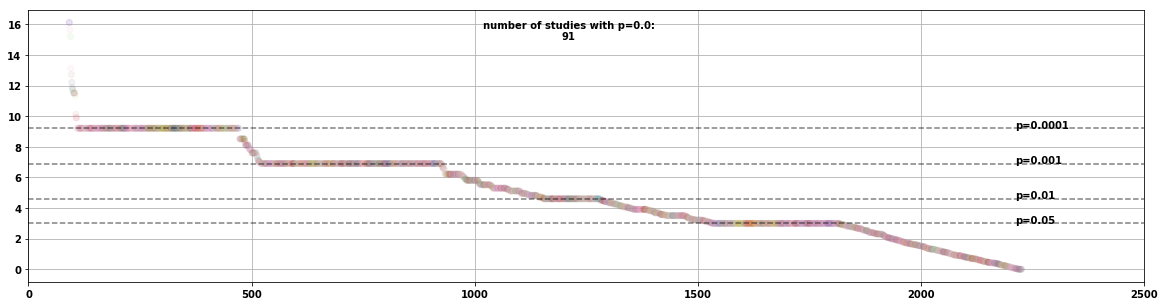

In [23]:
plt.figure(figsize=(20,5))
plt.scatter(range(nct_pvalues.shape[0]),nct_pvalues['min_pvalue'].sort_values(), alpha=0.1, c=[c_dict[i] for i in nct_pvalues.sort_values('min_pvalue')['year']], cmap='tab20')
plt.plot([0,12000], [0.05,0.05], 'k--',alpha=0.5)
plt.xlim(0,2500)


plt.figure(figsize=(20,5))
plt.scatter(range(nct_pvalues.shape[0]),nct_pvalues['min_pvalue'].sort_values().apply(lambda x: -np.log(x)), alpha=0.1,c=[c_dict[i] for i in nct_pvalues.sort_values('min_pvalue')['year']], cmap='tab20')

for pvalue in nct_pvalues['min_pvalue'].value_counts().index.tolist()[:5]:
    if pvalue==0:
        plt.text(1210, 15, 'number of studies with p=0.0:\n{}'.format((nct_pvalues['min_pvalue']==0).sum()), ha='center')
        continue
    plt.plot([0,2500], [-np.log(pvalue),-np.log(pvalue)], 'k--',alpha=0.5)
    plt.text(2210, -np.log(pvalue), 'p={}'.format(pvalue))
plt.xlim(0,2500)

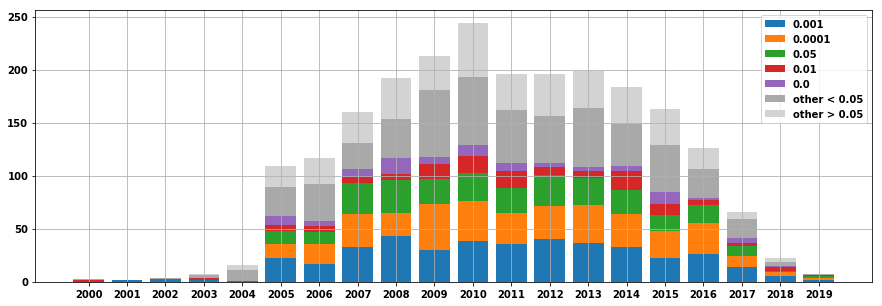

In [24]:
popular_pvalues = nct_pvalues['min_pvalue'].value_counts().index.tolist()[:5]

value_stack = {year:0 for year in sorted(nct_pvalues['year'].unique())}

def update_stack(row):
    value_stack[row['year']] += row['nct_id']

    

plt.figure(figsize=(15,5))    
    
for i, pval in enumerate(popular_pvalues):
    subset = nct_pvalues[nct_pvalues['min_pvalue']==pval].groupby('year')['nct_id'].nunique().reset_index()
    subset.apply(update_stack,axis=1)
    years, values = zip(*list(value_stack.items()))
    plt.bar(years,values, zorder=-i, label=pval)

    
i +=1    
non_pop_still_sig = nct_pvalues[
                                    (~nct_pvalues['min_pvalue'].isin(popular_pvalues)) & 
                                    (nct_pvalues['min_pvalue']<0.05)
    
                               ].groupby('year')['nct_id'].nunique().reset_index()
  
non_pop_still_sig.apply(update_stack,axis=1) 
years, values = zip(*list(value_stack.items()))
plt.bar(years,values, zorder=-i, label='other < 0.05', color='darkgrey')
    
all_pvals = nct_pvalues.groupby('year')['nct_id'].nunique().reset_index()
plt.bar(all_pvals['year'], all_pvals['nct_id'], label='other > 0.05', color='lightgrey', zorder=-(i+1))    
plt.legend()   
_ = plt.xticks( sorted(nct_pvalues['year'].unique()))